In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, librosa

from tensorflow.keras.layers import Dense, LSTM, Input, TimeDistributed, Bidirectional, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

In [6]:
def onehot(str):
    path = './Drum'
    kits = os.listdir(path)
    #kits.remove('.DS_Store')
    
    oh = []

    for kit in kits:
        if str == kit:
            oh.append(1)
        else:
            oh.append(0)
    
    return np.array(oh)

In [109]:
def make4096(wav):
    while len(wav) < 4096:
        wav = np.append(wav, np.array([0]))
    return wav[:4096]
            

In [77]:
CNN_INPUT_SIZE = (128, 20)
DEFAULT_SR = 22050

In [42]:
def resize_axis(array, N):
    if(array.shape[1] > N):
        resized = array[:,:N]
    else:
        resized = np.lib.pad(array, ((0,0),(0,N - array.shape[1])),\
            'constant', constant_values=(np.min(array)))
    return resized

In [88]:
def extract_cnn_input(raw_audio):
    frame_length = min(2048, len(raw_audio))
    mel_spec = librosa.core.power_to_db(librosa.feature.melspectrogram(
        y=raw_audio, sr=DEFAULT_SR, n_fft=frame_length,
        hop_length=frame_length//4, n_mels=CNN_INPUT_SIZE[0])
    )
    # Truncate number of frames stored
    m = min(CNN_INPUT_SIZE[1], mel_spec.shape[1])
    N = 20
    mell = resize_axis(mel_spec[:, 0:m], N)
    return mell

---

In [89]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        yt = librosa.util.normalize(yt)
        k = extract_cnn_input(yt)
        k = np.expand_dims(k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

In [110]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)
n=0

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        y_16k = librosa.resample(yt, orig_sr=sr, target_sr=16000)
        #yt16k = librosa.util.normalize(y_16k)
        n += len(y_16k)
        yt16k = make4096(y_16k)
        yt16k = np.expand_dims(yt16k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = yt16k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, yt16k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

In [112]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size=0.2)

In [91]:
# yy_test = np.argmax(y_test, axis = 1)
# yy_train = np.argmax(y_train, axis = 1)

x_train = x_train.reshape((560,1,4096))

---

In [129]:
units = 256
dropout = 0.2

model = tf.keras.models.Sequential()
forward_layer = tf.keras.layers.LSTM(units=units, dropout=dropout, recurrent_dropout=dropout)
backward_layer = tf.keras.layers.LSTM(units=units, activation='relu', go_backwards=True, dropout=dropout, recurrent_dropout=dropout)
model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(1,4096)))
# model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [130]:
with tf.device('/gpu:0'):
    history = model.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
16/16 [==============================] - 3s 45ms/step - loss: 1.8392 - accuracy: 0.2976 - val_loss: 1.7298 - val_accuracy: 0.3929
Epoch 2/5
16/16 [==============================] - 0s 25ms/step - loss: 1.3291 - accuracy: 0.7758 - val_loss: 1.6754 - val_accuracy: 0.4286
Epoch 3/5
16/16 [==============================] - 0s 25ms/step - loss: 1.0504 - accuracy: 0.8948 - val_loss: 1.6283 - val_accuracy: 0.5000
Epoch 4/5
16/16 [==============================] - 0s 25ms/step - loss: 0.8254 - accuracy: 0.9385 - val_loss: 1.5986 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 0s 25ms/step - loss: 0.6553 - accuracy: 0.9504 - val_loss: 1.5492 - val_accuracy: 0.5179


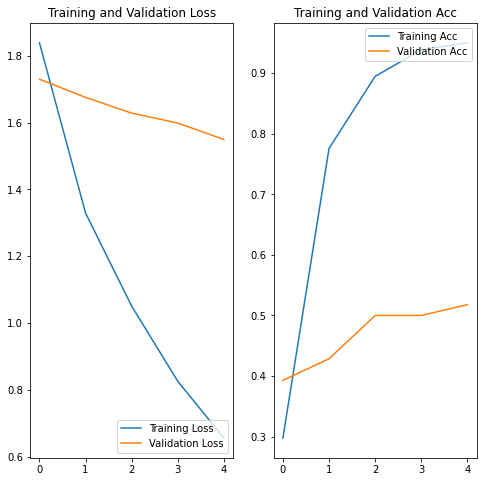

In [131]:
import matplotlib.pyplot as plt

acc = history.history['loss']
val_acc = history.history['val_loss']

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Acc')
plt.plot(epochs_range, val_loss, label='Validation Acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Acc')
plt.show()

In [141]:
y_pred =model.predict(x_test.reshape(x_test.shape[0],1,x_test.shape[1]))
ypred = np.argmax(y_pred,axis=1)

In [135]:
model.evaluate(x_test.reshape(x_test.shape[0],1,x_test.shape[1]),y_test)

5/5 [==============================] - 0s 6ms/step - loss: 1.6638 - accuracy: 0.4571


[1.6638104915618896, 0.4571428596973419]

<AxesSubplot:>

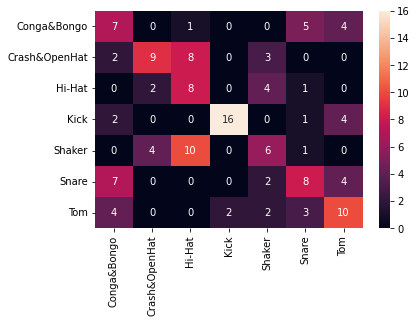

In [145]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

classes = ['Conga&Bongo', 'Crash&OpenHat', 'Hi-Hat', 'Kick', 'Shaker', 'Snare', 'Tom']

cm = pd.DataFrame(confusion_matrix(np.argmax(y_test,axis=1), ypred), columns=classes, index=classes)
sns.heatmap(cm, annot=True)